In [1]:
#General
import os
import json
import math
from collections import Counter

#Arrays/dataframe
import pandas as pd
import numpy as np

#Stats
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

#Images
from PIL import Image, ImageFont, ImageDraw
from IPython.display import display

# I. Import data

Import results from the card sorting study and create dataframe of the various categories 

In [2]:
#Create lookup table for sketch position in dataframe
sketch_dict = {}
sketch_names = []
counter = 0
for pt in range(1,29):
    for snd in range(1,11):
        for version in ['','B']:
            key = 'pt'+str(pt)+'snd'+str(snd)+version
            sketch_names.append(key)
            sketch_dict.update({key: counter})
            counter+=1

In [3]:
dataset_path = '../Card_Sorting_Results/' #Root folder for study results
pt_folders = os.listdir(dataset_path)
pt_folders.pop(0) #Remove first element because it contains some os descriptor
pt_folders.remove('Card_Sorting_Participant_6') #Remove categorisation by researcher

card_sorting = [] #Card Soring results will be stored in an array
category_names = [[],[]] #Category names of each participant, will be used as multi-column for dataframe
category_description = {} #Dictionary that holds description for each category

for pt_folder in pt_folders: #Go into participant folder
    for _, dirs, _ in os.walk(dataset_path+pt_folder): #Look into folders each participant        
        for category in dirs:
            category_names[0].append(pt_folder.replace('Card_Sorting_','')) #Save the participant ID
            category_names[1].append(category) #Save the category name
            sketches = np.zeros(560,dtype=int)
            for _,_,files in os.walk(dataset_path+pt_folder+'/'+category): #Look at files inside the category folder 
                for file in files:
                    key = file.split(".")
                    if key[1] == 'png':
                        #Check which sketches are inside this category
                        sketches[sketch_dict[key[0]]] = 1 
                    elif key[1] == 'txt':
                        #Read the description text file inside the folder
                        dsc = open(dataset_path+pt_folder+'/'+category+'/'+file,'r').read()
                        category_description.update({category:dsc})
                        
            card_sorting.append(sketches)

card_sorting = np.swapaxes(np.array(card_sorting),0,1)

In [4]:
with open('category_description.json','w') as fp:
    json.dump(category_description,fp)

In [5]:
#Create dataframe and save as csv
pd.MultiIndex.from_arrays(category_names, names=('Participant','Category Name'))
card_sorting_df = pd.DataFrame(card_sorting,columns=category_names,index=sketch_names)
#card_sorting_df.to_csv('card_sorting_raw.csv')
#card_sorting_df

# II. K-Means Clustering
Data is first reduced to 2 dimenstion with Principal Component Analysis (PCA) to tackle the sparsity of the original data. K-Means algorithm is then run on the resulting data and clusters are assessment with the Silhouette Coefficient. Cluster number is chosen according to the highest Silhouetee Coefficient in the range from 2 to 10.

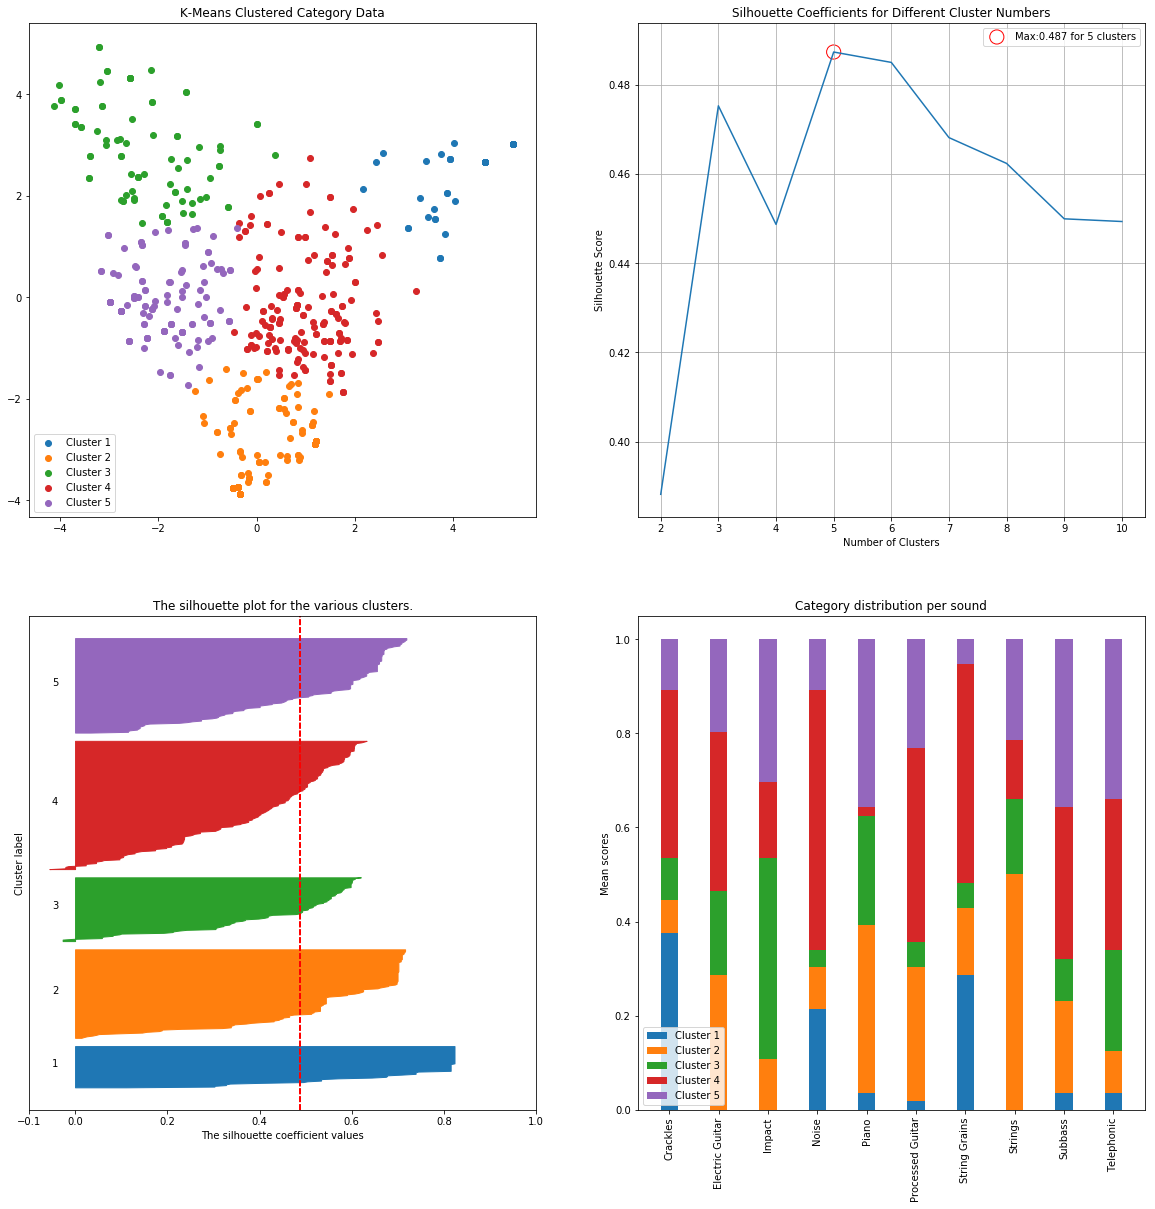

In [25]:
#-----------------------------------------------------------------------------
#PCA to 2 dimensions
#-----------------------------------------------------------------------------
card_sorting_std = StandardScaler().fit_transform(card_sorting)
pca = PCA(n_components=2)
card_sorting_pca = pca.fit_transform(card_sorting_std)

X = card_sorting_pca


#-----------------------------------------------------------------------------
#Find best number of clusters in range 2 to 10
#-----------------------------------------------------------------------------
P = [] #Cluster prediction
km = [] #KMeans data
sil_scores = [] #Silhouette Coefficients
limits = (2,11)
for number_of_clusters in range(limits[0],limits[1]):
    #K-Means clustering
    km.append(KMeans(n_clusters=number_of_clusters, random_state=0).fit(X))
    P.append(km[-1].predict(X))

    #Silhouette Coefficient for Cluster Quality Assessment
    labels = km[-1].labels_
    sil_scores.append(metrics.silhouette_score(X, labels, metric='euclidean'))

max_sil_score = max(sil_scores) #Highest Silhouette Coeffecient
max_sil_index = sil_scores.index(max_sil_score) #Index of highest score 
number_of_clusters = max_sil_index + limits[0] #The number of clusters related to the highest Silhouette score

#-----------------------------------------------------------------------------
#Create dataframe with category data per participant and sound
#-----------------------------------------------------------------------------
sound_index = ['Crackles','Telephonic','Strings','String Grains','Subbass','Noise','Piano','Impact','Processed Guitar','Electric Guitar']
pt_number = []
for pt in range(1,29):
    for suffix in ['','B']:
        pt_number.append('Pt'+str(pt)+suffix)
        
cluster_array = np.zeros((10,56),dtype=int)
for pt in range(28):
    for snd in range(10):
        for i in range(2):
            index = 20*pt + 2*snd + i
            cluster_array[snd,2*pt+i] = P[max_sil_index][index]
cluster_df = pd.DataFrame(cluster_array,columns=pt_number,index=sound_index)
#Save dataframe
cluster_df.to_csv('sketches_assigned_to_clusters.csv')

#-----------------------------------------------------------------------------
#-----------------------------------------------------------------------------

#-----------------------------------------------------------------------------
#Visualise data
#-----------------------------------------------------------------------------
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
#Use standard colour palett
prop_cycle = plt.rcParams['axes.prop_cycle']
colour = prop_cycle.by_key()['color']

#-----------------------------------------------------------------------------
#Visualise clusters
#-----------------------------------------------------------------------------
axes[0,0].set_title('K-Means Clustered Category Data')
for cluster in range(number_of_clusters):
    indices = np.where(P[max_sil_index]==cluster)
    points = []
    for i in indices:
        points.append(X[i])
    axes[0,0].scatter(points[0][:,0],points[0][:,1],c=colour[cluster],label='Cluster ' + str(cluster+1))

axes[0,0].legend(loc='lower left')

#-----------------------------------------------------------------------------
#Visualise Silhouette scores
#-----------------------------------------------------------------------------
axes[0,1].set_title('Silhouette Coefficients for Different Cluster Numbers')
axes[0,1].set_xlabel('Number of Clusters')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].plot(range(limits[0],limits[1]),sil_scores)
axes[0,1].grid()
label = 'Max:' + "{0:.3f}".format(max_sil_score) + ' for ' + str(number_of_clusters) + ' clusters'
axes[0,1].scatter(number_of_clusters,max_sil_score,c=[(0,0,0,0),(0,0,0,0)],edgecolors='r',s=200,label=label)
axes[0,1].legend(loc='upper right')

#-----------------------------------------------------------------------------
#Display silhouette plot
#-----------------------------------------------------------------------------
labels = km[max_sil_index].labels_
sil_values = metrics.silhouette_samples(X, labels, metric='euclidean')
np.shape(sil_values)

y_lower = 10
for i in range(number_of_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sil_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    axes[1,0].fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colour[i], edgecolor=colour[i])

    # Label the silhouette plots with their cluster numbers at the middle
    axes[1,0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    axes[1,0].set_title("The silhouette plot for the various clusters.")
    axes[1,0].set_xlabel("The silhouette coefficient values")
    axes[1,0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axes[1,0].axvline(x=sil_scores[max_sil_index], color="red", linestyle="--")

    axes[1,0].set_yticks([])  # Clear the yaxis labels / ticks
    axes[1,0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
#-----------------------------------------------------------------------------
#Display category distribution per sound
#-----------------------------------------------------------------------------
nos = 10 #Number of sounds
nop = 28 #Number of participants
cats = np.zeros((number_of_clusters,nos))
    
for i in range(2*nop):
    for j in range(nos):
        cat = cluster_df.iloc[j,i]
        cats[cat,j] += 1

#Grouped Bar Plot
labels = sound_index
width = 0.35       # the width of the bars: can also be len(x) sequence
bt = np.zeros(nos) # y positions of stacked bars
for cat in range(number_of_clusters):
    h = cats[cat,:]/(2*nop)
    axes[1,1].bar(labels, h, width, bottom=bt, label='Cluster ' + str(cat+1), color=colour[cat])
    bt += h 
axes[1,1].set_ylabel('Mean scores')
axes[1,1].legend(loc='lower left')

for tick in axes[1,1].get_xticklabels():
      tick.set_rotation(90)
axes[1,1].set_title('Category distribution per sound')

plt.show()

In [7]:
#Function to display info about clusters
def display_cluster_info(sketch_indices,threshold=0):
    categories = []
    path = '../Sketches/'
    
    for k,i in enumerate(sketch_indices[0]):
        sketch_name = sketch_names[int(i)]
        sketch_row = card_sorting_df.loc[sketch_name]
        categories.extend(sketch_row[sketch_row[:]>0].index.to_list())        
    
    count_categories = Counter(categories)
    for key in count_categories:
        if count_categories[key] > np.size(sketch_indices)*threshold:
            print(key[1] + ' by ' + key[0] + ' occurs ' + str(count_categories[key]) + ' times')
            print('Category Description: ' + category_description[key[1]] + '\n')
            
    print('__________________________________________________________________________ \n')

def display_cluster_sketches(sketch_indices):
    categories = []
    path = '../Sketches/'
    x_line = 8 #Number of sketches in a row
    border = 2 #Width of border between sketches
    dst = Image.new('RGBA', ((750+border)*x_line-border,(750+border)*math.ceil(np.size(sketch_indices)/x_line)),color = (0,0,0,255))

    for k,i in enumerate(sketch_indices[0]):
        sketch_name = sketch_names[int(i)]
        
        #Draw sketch name
        image_label = Image.new(mode = 'RGBA', size=(750,100))
        draw = ImageDraw.Draw(image_label)
        font = ImageFont.truetype("ARIAL.TTF", 70)
        draw.text((10,10),sketch_name,font=font,fill=(255,0,0))
        
        #Display Sketches
        pt_number = math.floor(i/20) + 1
        sketch = Image.open(path + 'Participant' + str(pt_number) + '/' + sketch_name + '.png')
        pos = ((750+border)*(k%x_line),(750+border)*math.floor(k/x_line))
        dst.paste(sketch,pos)
        dst.paste(image_label,pos)
        
    display(dst)
        
    print('__________________________________________________________________________ \n')

In [8]:
#Description of cluster
threshold = 0.1
for cluster in range(number_of_clusters):
    sketch_indices = np.where(P[max_sil_index]==cluster)
    print('Cluster ' + str(cluster+1) + ' Size: ' + str(np.size(sketch_indices)))
    print('At least ' + "{0:.0f}".format(threshold*100) + '% of items were tagged with the following categories:\n')
    display_cluster_info(sketch_indices,threshold)
        

Cluster 1 Size: 56
At least 10% of items were tagged with the following categories:

rhythmic by Participant_1 occurs 51 times
Category Description: Rhythmic

In these pictures there are a lot of small structures which are similar in shape and spaced similarly apart. These strike me as being regular repeating patterns or separate notes/pulses, and like the drawer is depicting the repetition of the sound they hear by drawing multiple small images. The especially small size of the drawings, perhaps done quickly. It seems to me that the drawers were trying to focus on the repetition or articulation of the sound in doing this.

multiple_instances by Participant_4 occurs 53 times
Category Description: multiple instances of a single object, whether it is a line or shape


Grainy by Participant_3 occurs 31 times
Category Description: 

Abstract_MultipleSimilarComponents by Participant_5 occurs 47 times
Category Description: 

Category Name: Abstract_Multiple Similar Components


This category

Frenzy by Participant_7 occurs 57 times
Category Description: 
Frenzy - more chaotic, scratchy drawings




jagged by Participant_1 occurs 52 times
Category Description: jagged

These cards all have some sort of jagged or rapidly moving lines that move suddenly and can appear sort of abrasive or chaotic. I think these were sounds which changed quickly or were either distorted or were comprised of pulse-based waves (saws and squares). Sort of crunchy sounding at the least. This was the most difficult category for me to sort, as I felt like maybe some of them could have been in multiple categories, but I imagine that the participants were mostly focusing on the quality of the sound itself in order to be drawing out these sharp jagged lines.

jittery_abstract by Participant_4 occurs 72 times
Category Description: abstract representations that are erratic, jagged, irregular, sometimes portraying violent or chaotic gestures

Noise by Participant_2 occurs 24 times
Category Description: NOISE

## Summary of cluster descriptions:

For the full thematic analysis of the desriptions of categories prevelant in the different clusters see: https://docs.google.com/document/d/1qcmdoFofwA4gAPDv5YhrPAe6Z8x8wNqu2H5wE7hS3qc/edit?usp=sharing 

The cluster names, descriptions and keywords are extracted from the card sorting participants' category descriptions. Not all sketches match those labels entirely. 

- **Cluster 1: Grains**
    - Repeated distinct abstract elements
    - Keywords: Small, repeated, grainy, spots, multiple components, layers, abstract, distinct

- **Cluster 2: Lines**
    - Small number of long lines following various shapes
    - Keywords: round,soft,continuous, jagged, irregular, continuous, simple, single, lines
    
- **Cluster 3: Objects/Scenes**
    - Depictions of real-life scenarios with occasional abstract influences
    - Keywords: real-life objects, environment, actions or feelings, abstract structures

- **Cluster 4: Chaotic/Jagged**
    - Chaotic, jagged sketches; single or multiple elements
    - Keywords: chaotic, intense, jagged, multiple layers, single objects
    
- **Cluster 5: Radiating**
    - Sketches that evolve from a common, central origin
    - Keywords: round, circular, spiral, sharp, shaking, distinct objects, radiating, natural shapes






Cluster 1 Size: 56


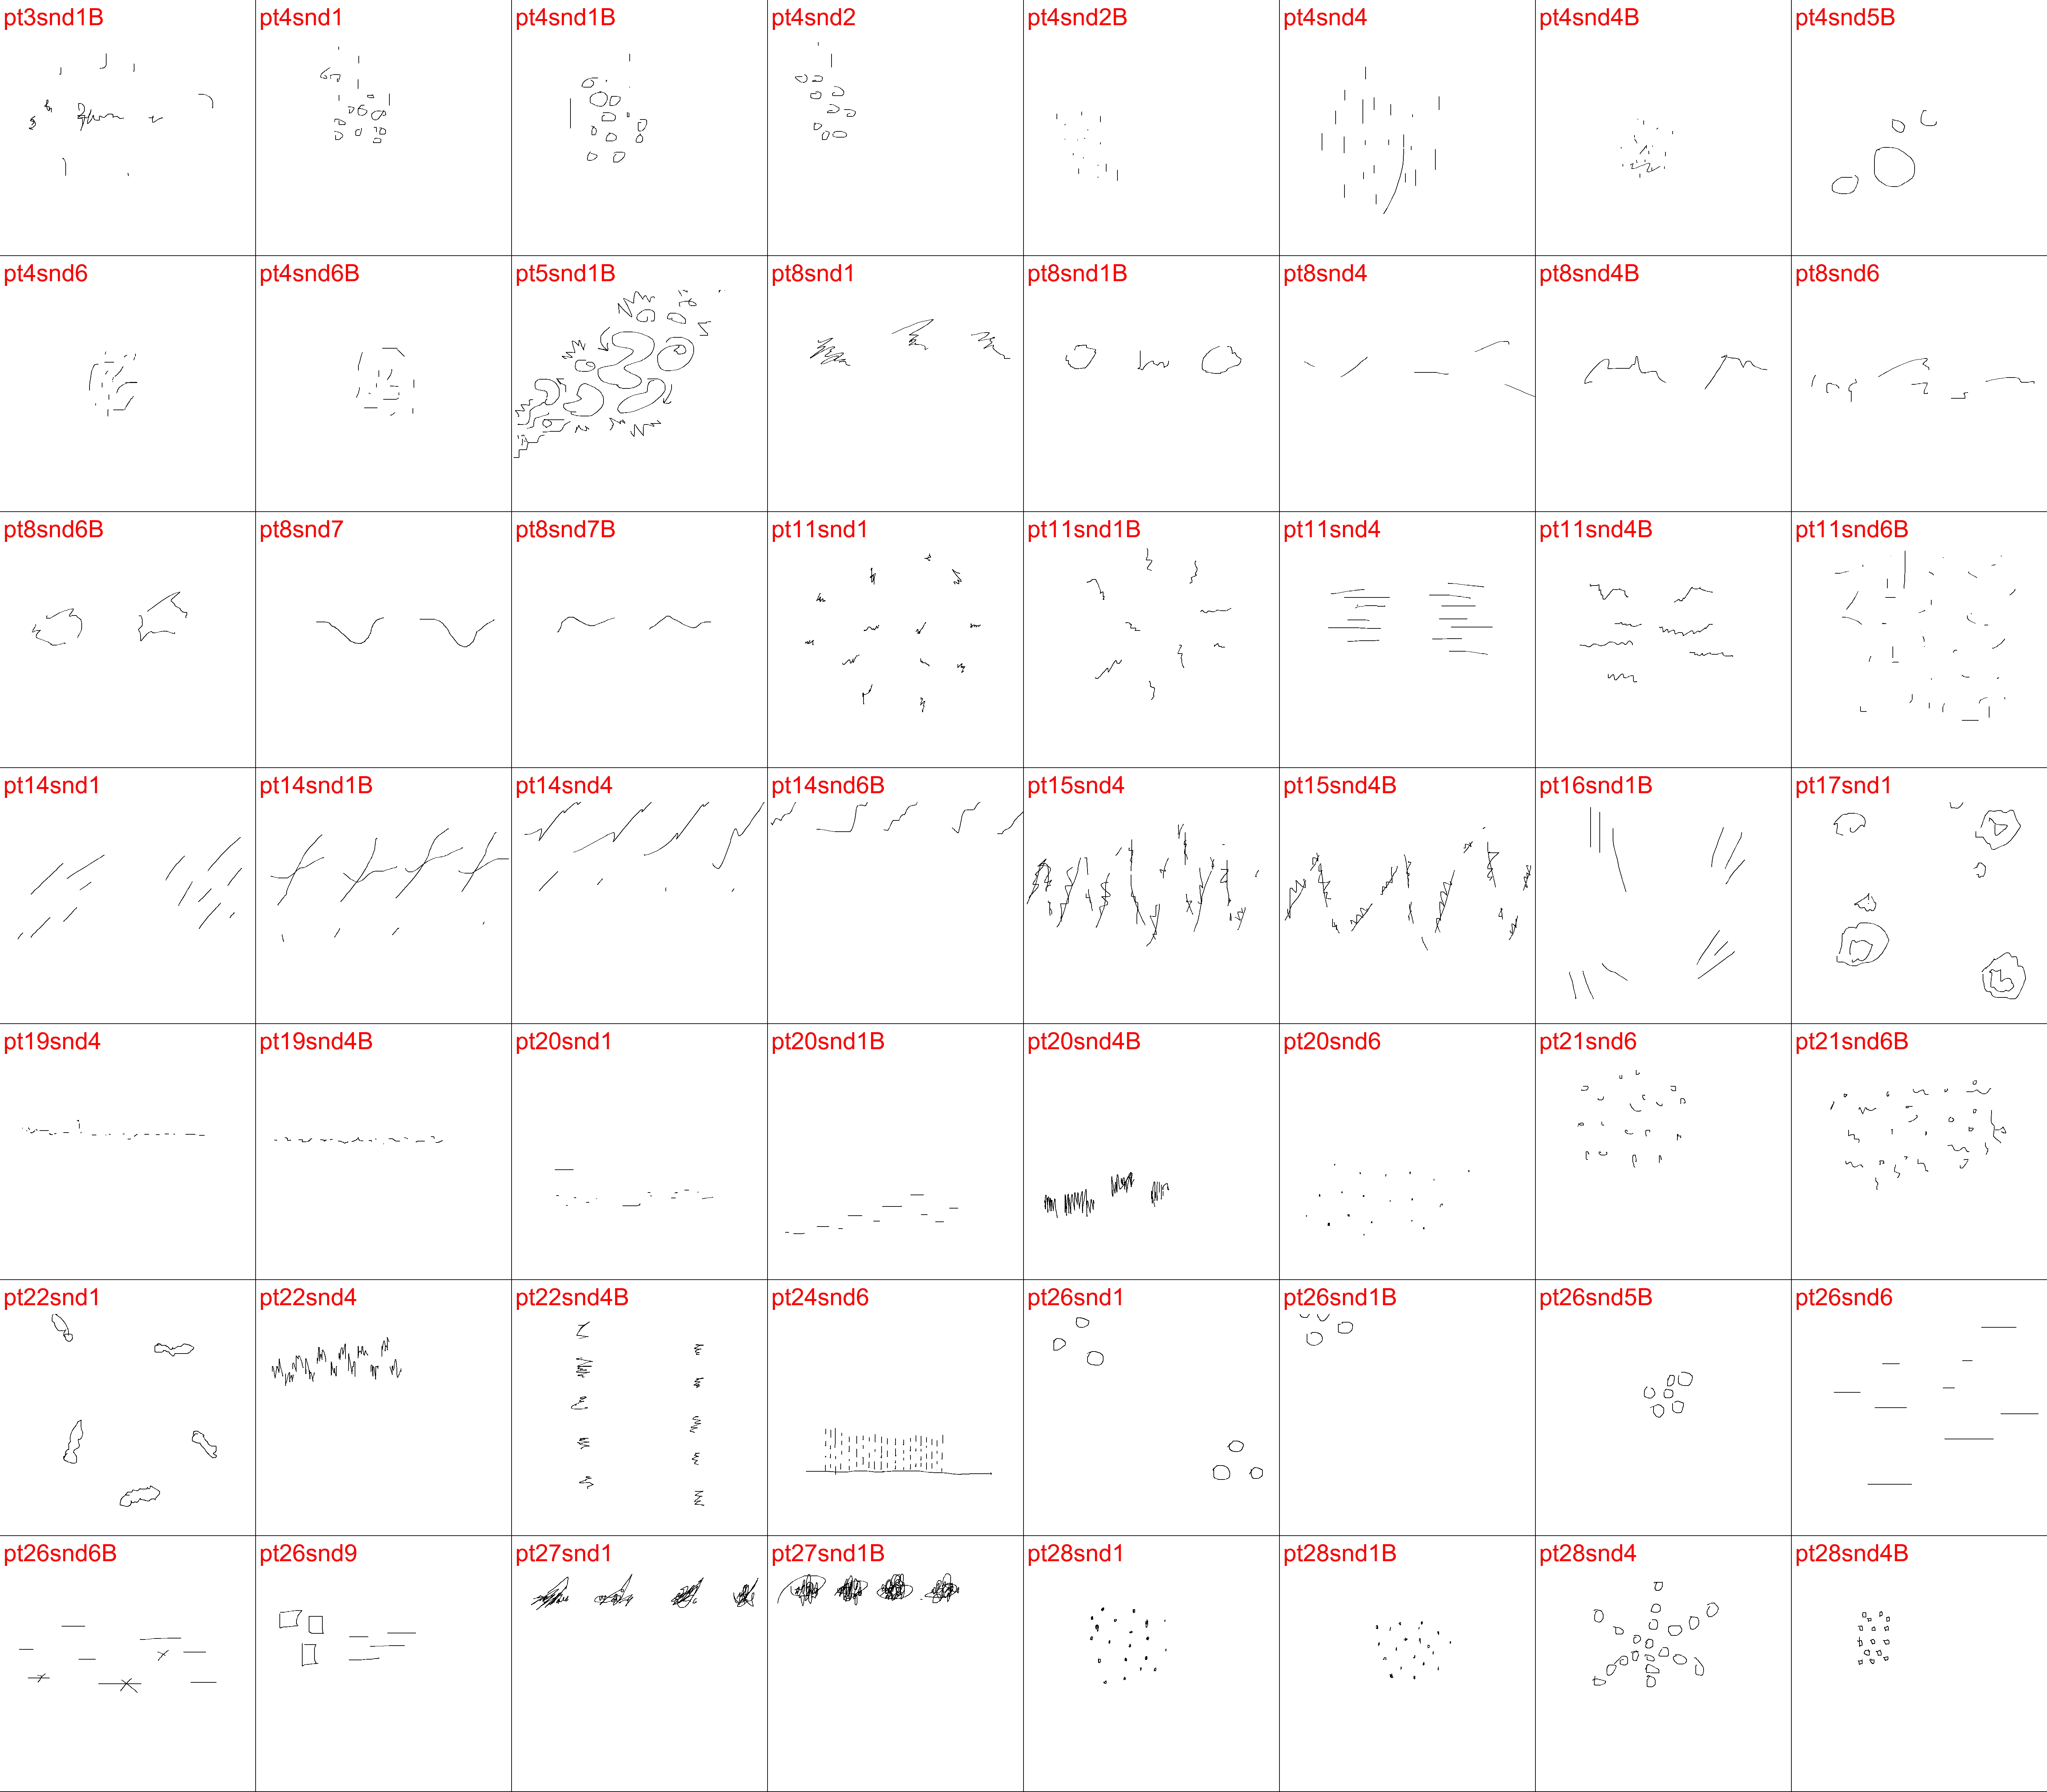

__________________________________________________________________________ 

Cluster 2 Size: 119


__________________________________________________________________________ 

Cluster 3 Size: 86


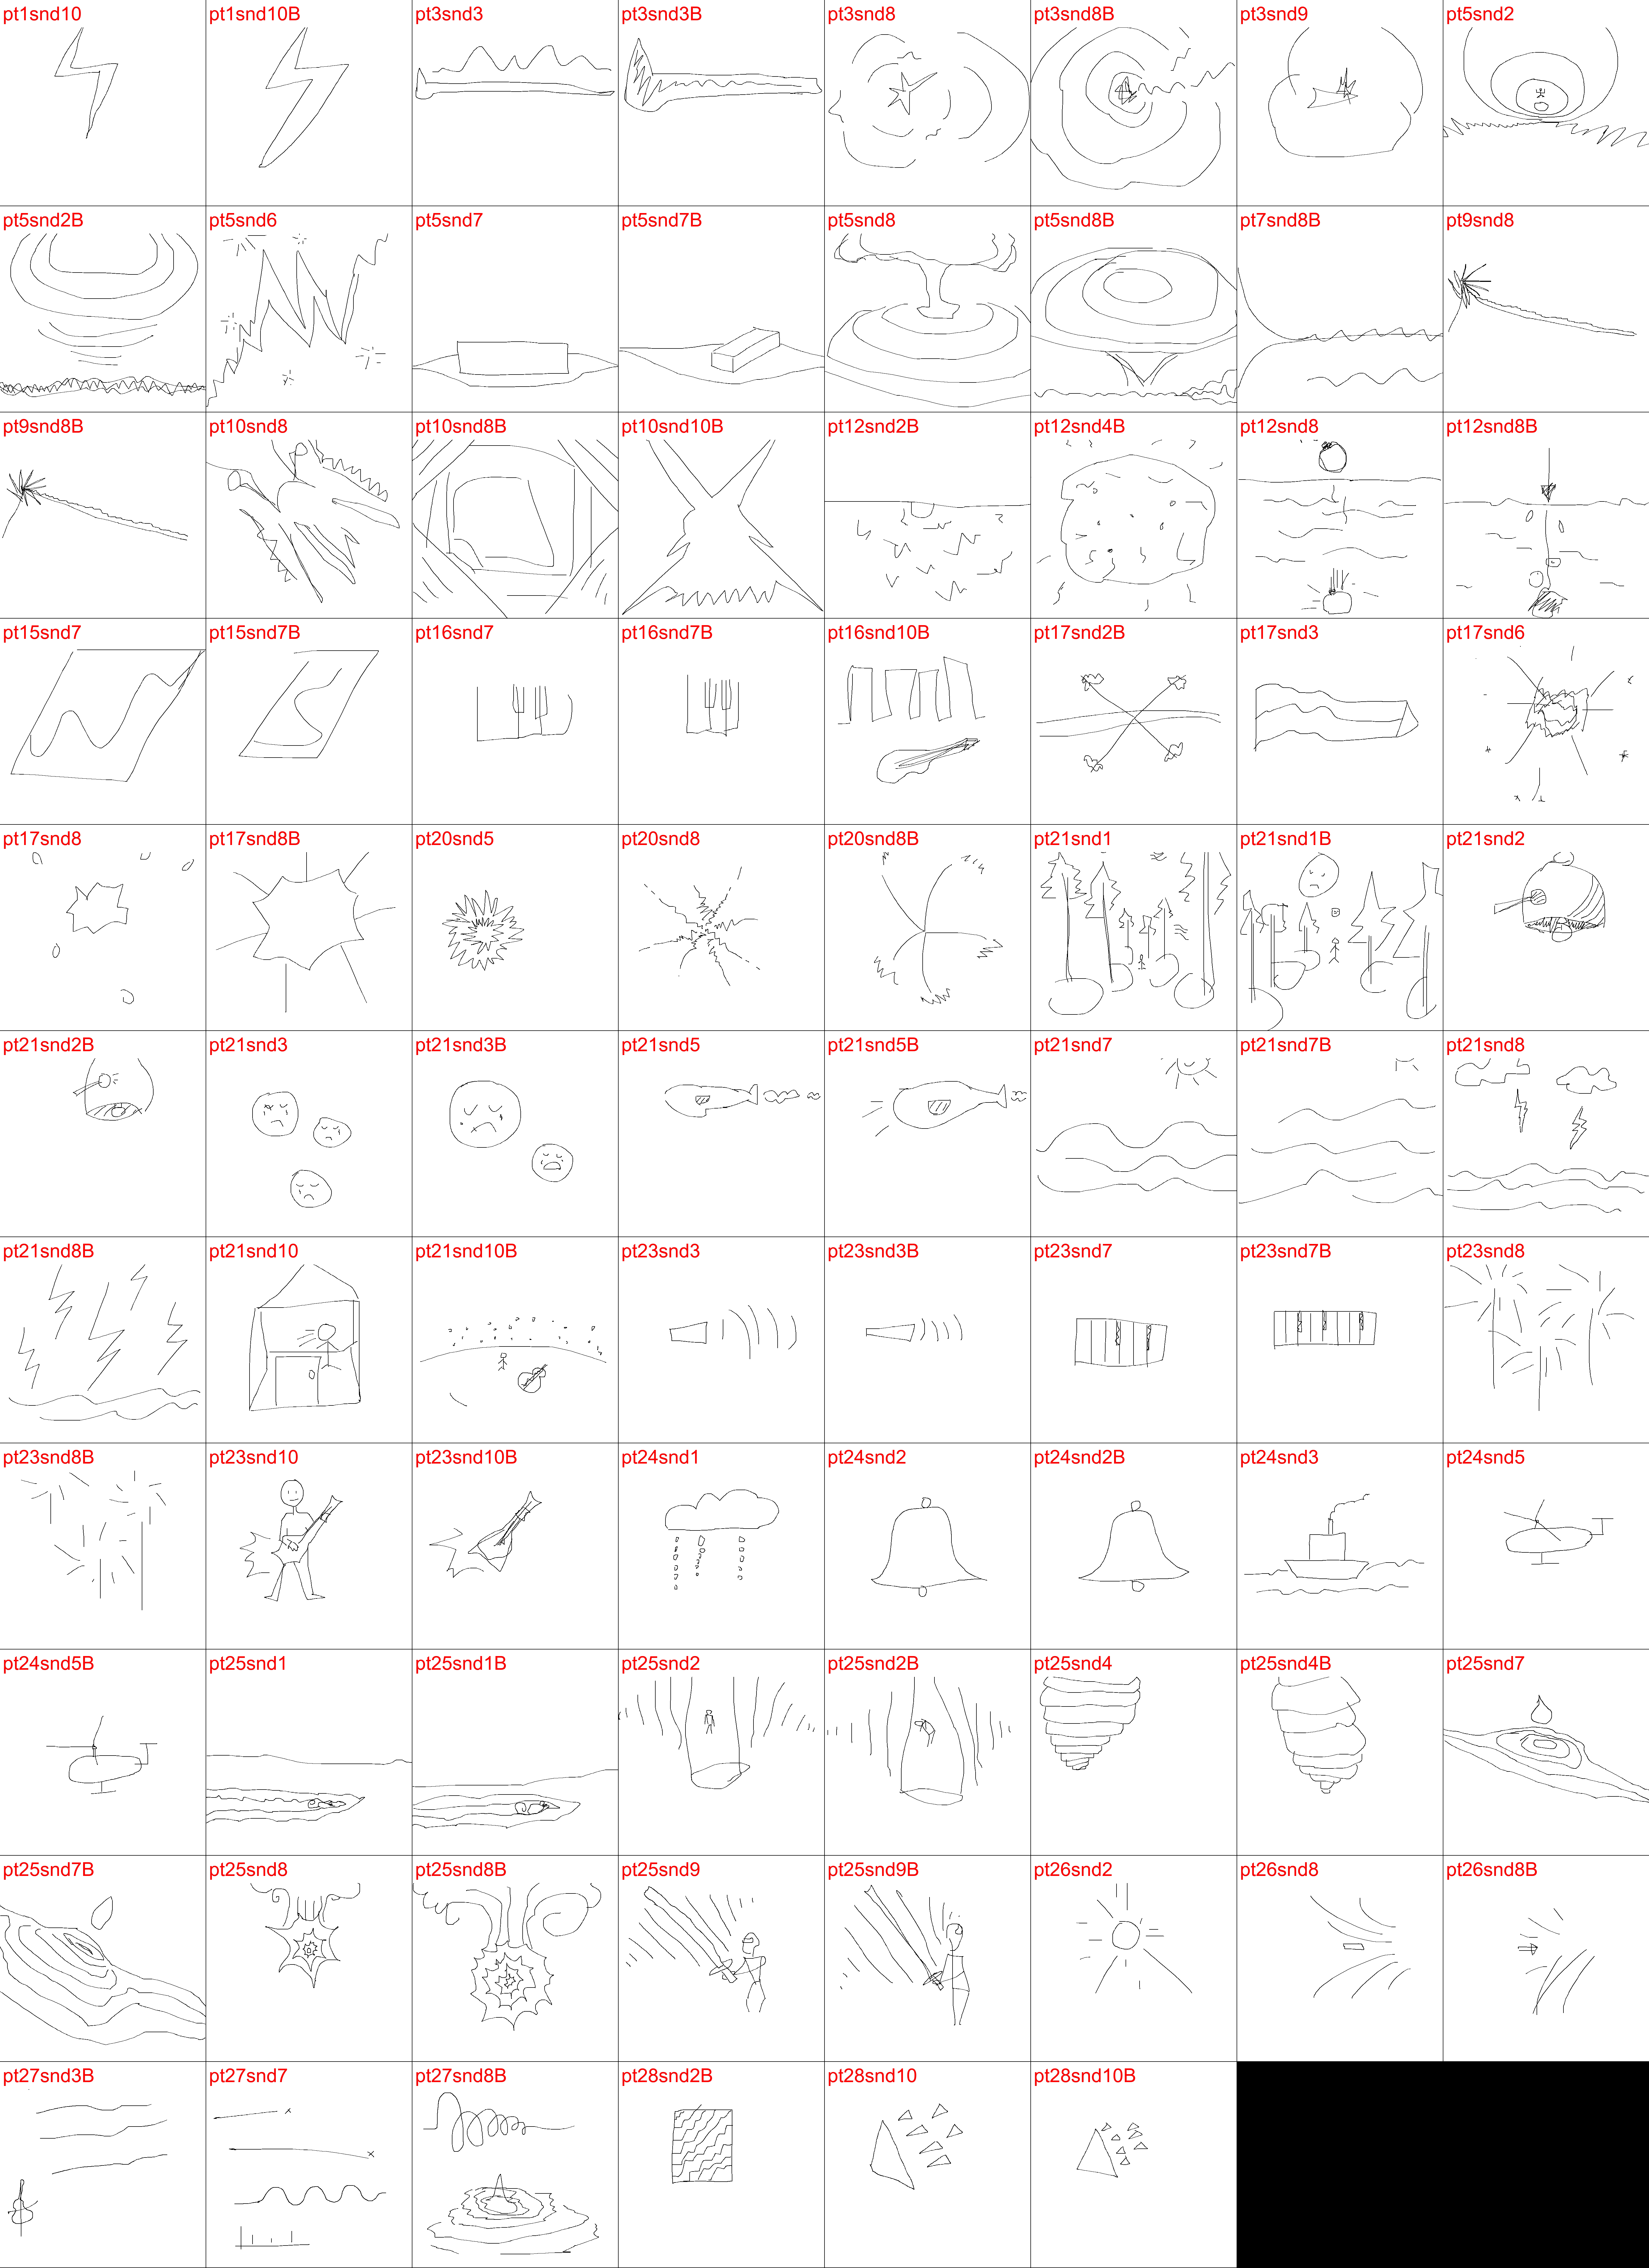

__________________________________________________________________________ 

Cluster 4 Size: 172


__________________________________________________________________________ 

Cluster 5 Size: 127


__________________________________________________________________________ 



In [9]:
#Sketches in each cluster
for cluster in range(number_of_clusters):
    sketch_indices = np.where(P[max_sil_index]==cluster)
    print('Cluster ' + str(cluster+1) + ' Size: ' + str(np.size(sketch_indices)))
    display_cluster_sketches(sketch_indices)

# III. Hierarchical Clustering

Card sorting results can also be grouped through hierarchical clustering; a process that can be visualised through a dendogram. However, in this case even in the top layers, hierarchicial clustering produced 10+ categories which is undesirable for this application.

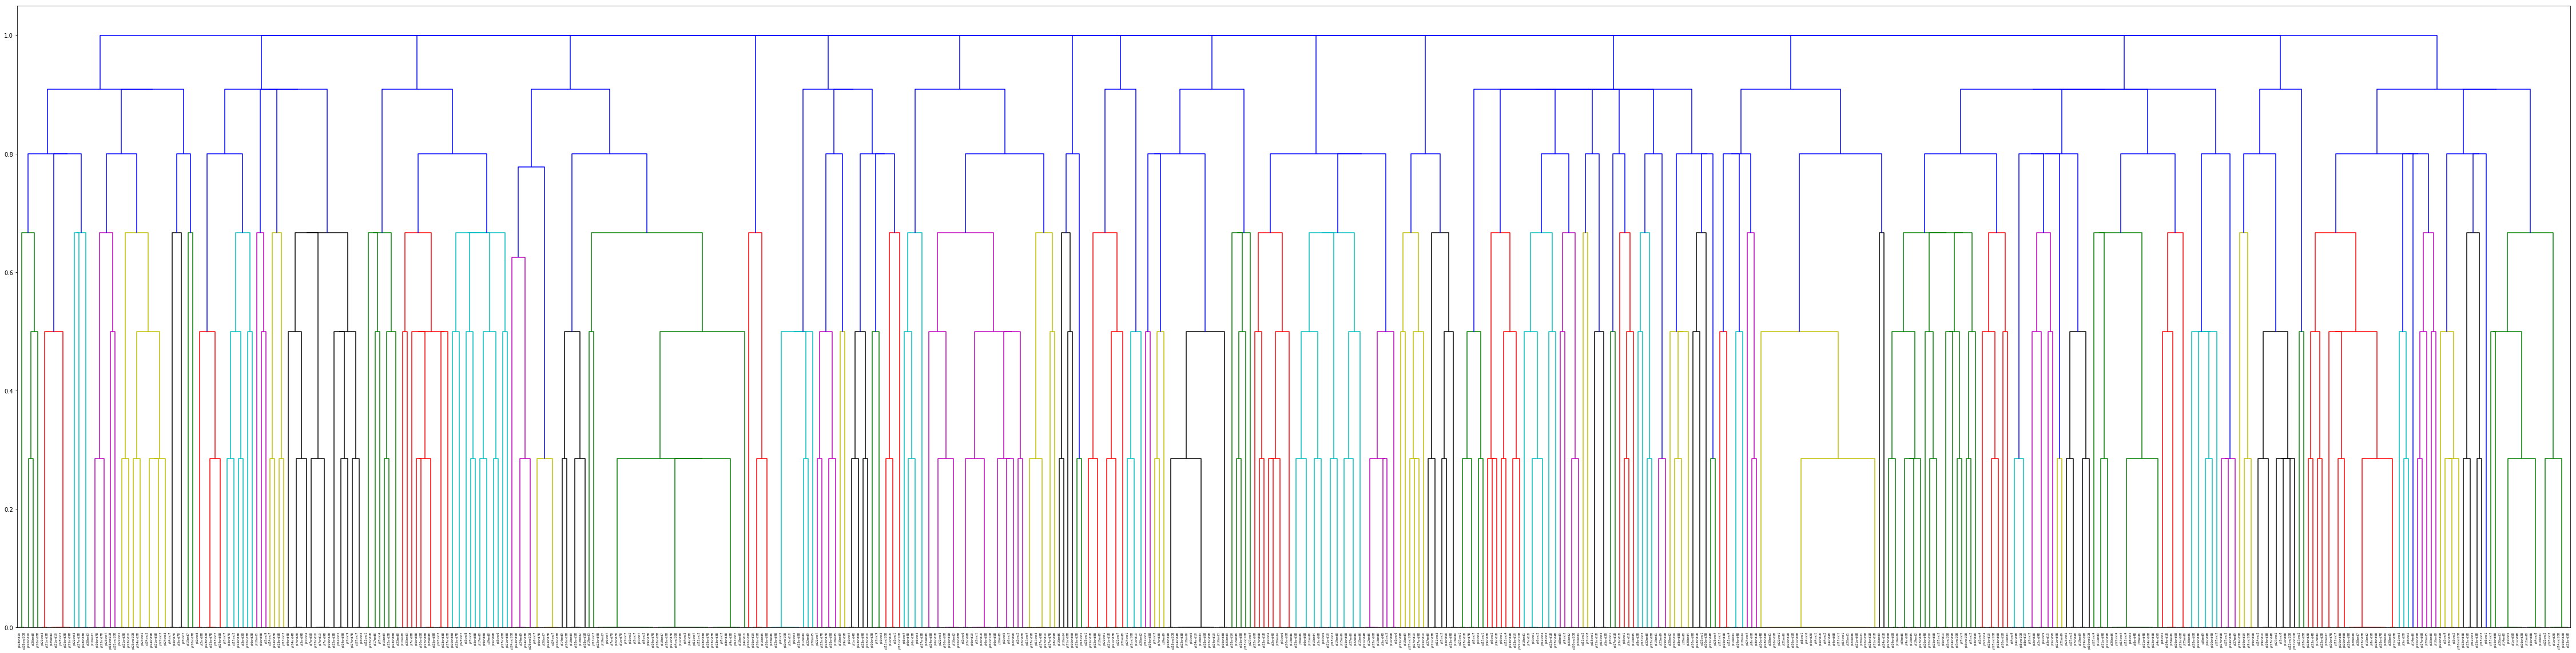

In [13]:
metric = 'jaccard'
ytdist = ssd.pdist(card_sorting,metric=metric)
#Nearest neighbour (single) does not give a good structure because of small sample size
Z = hierarchy.linkage(ytdist, 'complete',optimal_ordering=True,metric=metric)

plt.figure(figsize=(80,20))

dn = hierarchy.dendrogram(Z,labels=sketch_names)

plt.savefig('dendogram.png',dpi=120)

In [14]:
T = hierarchy.fcluster(Z,t=0.9,criterion='distance')
leaders=hierarchy.leaders(Z,T)

In [15]:
#Display hierarchical cluster info
'''
for cluster in range(1,np.max(T)+1):    
    sketch_indices = np.where(T == cluster)
    print('Cluster ' + str(cluster) + ': ' + str(len(sketch_indices[0])) + ' Elements \n')
    display_cluster_info(sketch_indices)
'''

"\nfor cluster in range(1,np.max(T)+1):    \n    sketch_indices = np.where(T == cluster)\n    print('Cluster ' + str(cluster) + ': ' + str(len(sketch_indices[0])) + ' Elements \n')\n    display_cluster_info(sketch_indices)\n"